In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt 
import matplotlib
from collections import Counter
# pd.options.plotting.backend = 'plotly'
matplotlib.rcParams['font.family'] ='Malgun Gothic'

from datetime import timedelta
import datetime

In [ ]:
# Collections of function

def load_data_and_set_date_state(start_date, end_date, data):
    '''
    Data load and drop na \n
    Setting start date and end date
    '''

    i=0
    # data = pd.read_csv('대한수학회 공유확진자DB_220321_' + str(i+1) + '.csv', low_memory=False)

    data = data[['거주시군구', '거주시도', '발병일', '신고일', '연령', '위중증 유무(유:1)', '사망유무(유:1)', '선행확진자_번호']]
    data.dropna(subset=['신고일'], axis=0, inplace=True)
    data.dropna(subset=['거주시도'], axis=0, inplace=True)
    data = data.fillna(0)
    data['신고일'] = pd.to_datetime(data['신고일'], format="%Y-%m-%d")
    data = data[(data['신고일'] >= pd.to_datetime(start_date, format="%Y-%m-%d")) & (data['신고일'] <= pd.to_datetime(end_date, format="%Y-%m-%d"))]
    data['확진자'] = [1]*len(data)
    return data

def load_data_and_set_date_city(start_date, end_date, data):
    '''
    Data load and drop na \n
    Setting start date and end date
    '''

    i=0
    # data = pd.read_csv('대한수학회 공유확진자DB_220321_' + str(i+1) + '.csv', low_memory=False)

    data = data[['거주시군구', '거주시도', '발병일', '신고일', '연령', '위중증 유무(유:1)', '사망유무(유:1)', '선행확진자_번호', '지역세분화']]
    data.dropna(subset=['신고일'], axis=0, inplace=True)
    data.dropna(subset=['지역세분화'], axis=0, inplace=True)
    
    print(data.fillna(0))
    
    data = data.fillna(0)
    
    print(data)
    
    data['신고일'] = pd.to_datetime(data['신고일'], format="%Y-%m-%d")
    data = data[(data['신고일'] >= pd.to_datetime(start_date, format="%Y-%m-%d")) & (data['신고일'] <= pd.to_datetime(end_date, format="%Y-%m-%d"))]
    data['확진자'] = [1]*len(data)
    return data

def make_dummy_date(start_date, end_date):
    '''
    Fill date of empty part
    '''

    start_y = int(start_date[0:4])
    start_m = int(start_date[5:7])
    start_d = int(start_date[8:10])
    end_y = int(end_date[0:4])
    end_m = int(end_date[5:7])
    end_d = int(end_date[8:10])

    diff_days = datetime.date(end_y,end_m,end_d) - datetime.date(start_y,start_m,start_d)
    
    date_list, week_list = [], []
    for i in range(diff_days.days+1): # +1 해줘야 지정한 날 마지막까지 감.
        date_list.append(datetime.date(start_y, start_m, start_d) + timedelta(days=i))
        
    for i in range(int(diff_days.days/7)):
        week_list.append(datetime.date(start_y, start_m, start_d) + timedelta(weeks=i))
        
    date_df = pd.DataFrame({'신고일' : date_list})
    week_df = pd.DataFrame({'신고주' : week_list})
    return date_df, week_df


def define_daily_dataframe(data, date_df, region, category):

    '''
    daily confirmed case and unlinked ratio
    '''
    if category == 'city':
        data = data[data['지역세분화'] == region]
    elif category == 'state':
        data = data[data['거주시도'] == region]
        
    data['신고일'] = data['신고일'].apply(lambda x: x.date())
    daily_data = pd.DataFrame({})
    daily_data['신고일'] = data['신고일'].value_counts().index
    daily_data['확진자'] = data['신고일'].value_counts().values
    
    unlinked_ratio = []
    for c_date in daily_data['신고일']:
        
        # 해당 신고일에 선행확진자 번호가 0인 사람을 카운트해서 비율로 추가
        tmp = data['선행확진자_번호'][data['신고일'] == c_date]
        unlinked_ = tmp.value_counts()[0]
        length = len(tmp)
        unlinked_ratio.append(unlinked_/length)
    
    # daily_data = preprocessing_01(daily_data, date_df, unlinked_ratio, region, region_idx, '신고일')
    daily_data = preprocessing_01(daily_data, date_df, unlinked_ratio, region, '신고일')
    # daily case는 연령별 추가 안해뒀음.
    return daily_data

def define_weekly_dataframe(data, week_df, region):
    
    '''
    weekly confirmed case and unlinked ratio
    '''
    weekly_data = pd.DataFrame({})
    week_case,week_date = [], []
    unlinked_ratio = []
    age_under_20 = []
    age_under_30 = []
    age_under_40 = []
    age_under_50 = []
    age_under_60 = []
    age_under_70 = []
    age_under_80 = []
    age_etc = []
     
    data = data[data['거주시도'] == region]
    data['신고일'] = data['신고일'].apply(lambda x: x.date())
    
    for w_date in week_df['신고주']:
        week_sum = ((data['신고일'] >= w_date) & (data['신고일'] < w_date + timedelta(weeks=1))).sum()
        week_case.append(week_sum)
        week_date.append(w_date)
        
    # weekly_data['신고주'] = week_date
    # weekly_data['확진자'] = week_case
    # for w_date in weekly_data['신고주']:
        
        tmp = data[(data['신고일'] >= w_date) & (data['신고일'] < w_date + timedelta(weeks=1))]
        
        age_group_list = add_age_group(tmp)
        age_under_20.append(age_group_list[0]/week_sum)
        age_under_30.append(age_group_list[1]/week_sum)
        age_under_40.append(age_group_list[2]/week_sum)
        age_under_50.append(age_group_list[3]/week_sum)
        age_under_60.append(age_group_list[4]/week_sum)
        age_under_70.append(age_group_list[5]/week_sum)
        age_under_80.append(age_group_list[6]/week_sum)
        age_etc.append(age_group_list[7]/week_sum)
        
        
        # 선행확진자 번호가 0인 사람이 없다면 unlinked ratio를 0으로, 아니라면 unlinked의 비율을 추가
        if len(tmp[tmp['선행확진자_번호'] == 0]) == 0:
            unlinked_ratio.append(0)
        else:
            unlinked_ = tmp['선행확진자_번호'].value_counts()[0]
            length = len(tmp)
            unlinked_ratio.append(unlinked_/length)
            
    weekly_data['신고주'] = week_date
    weekly_data['확진자'] = week_case
    weekly_data = preprocessing_01(weekly_data, week_df, unlinked_ratio, region, '신고주')
    weekly_data = preprocessing_02(weekly_data, age_under_20, age_under_30, age_under_40, age_under_50, age_under_60, age_under_70, age_under_80, age_etc)

    return weekly_data
    
def preprocessing_01(data, date_df, unlinked_ratio, region, sorting_criterion):
    ''' 
    daily, weekly data preprocessing and add unlinked case \n
    sorting_criterion = 신고일, 신고주
    '''

    # data['unlinked_ratio'] = unlinked_ratio
    # data['unlinked_ratio'].astype(float)
    
    data = pd.merge(data, date_df, how='outer')
    # data['거주시도'] = region # 번호로 해주니까 없어도 될듯
    # data['region_idx'] = region_idx # 이거도 필요없음
    data.fillna(0, inplace = True) # 날짜 합치면서 생기는 NaN 0으로 변환
    data.sort_values(by=sorting_criterion, inplace=True) # date 기준으로 sort
    data.index = [i for i in range(len(data))] # merge하면서 뒤죽박죽인 index를 다시 0부터
    # data['time_idx'] = [i for i in range(len(data))] # DeepAR 할때 필요한거
    
    # data.rename(columns = {sorting_criterion:'date', '확진자' : 'value'},inplace=True)
    data.rename(columns = {sorting_criterion:'date', '확진자' : region},inplace=True)
    del data['date']
    return data

def add_age_group(tmp):

    age_group_list = []
    age_group_list.append(len(tmp[tmp['연령'] < 20]))
    age_group_list.append(len(tmp[(tmp['연령'] < 30) & (tmp['연령'] >=20)]))
    age_group_list.append(len(tmp[(tmp['연령'] < 40) & (tmp['연령'] >=30)]))
    age_group_list.append(len(tmp[(tmp['연령'] < 50) & (tmp['연령'] >=40)]))
    age_group_list.append(len(tmp[(tmp['연령'] < 60) & (tmp['연령'] >=50)]))
    age_group_list.append(len(tmp[(tmp['연령'] < 70) & (tmp['연령'] >=60)]))
    age_group_list.append(len(tmp[(tmp['연령'] < 80) & (tmp['연령'] >=70)]))
    age_group_list.append(len(tmp[tmp['연령'] >= 80]))
    
    return age_group_list


def preprocessing_02(weekly_data, age_under_20, age_under_30, age_under_40, age_under_50, age_under_60, age_under_70, age_under_80, age_etc):
    
    weekly_data['<20'] = age_under_20
    weekly_data['<30'] = age_under_30
    weekly_data['<40'] = age_under_40
    weekly_data['<50'] = age_under_50
    weekly_data['<60'] = age_under_60
    weekly_data['<70'] = age_under_70
    weekly_data['<80'] = age_under_80
    weekly_data['>80'] = age_etc
    
    return weekly_data

In [ ]:
data_test = pd.read_csv('Data/Confirmed_Case_DB_220321_1.csv', low_memory=False)
data_test['지역세분화'] = (data_test['거주시도'] + ' ' + data_test['거주시군구'])

# 예외처리
data_test['거주시도'][data_test['거주시도'] == '대구시'] = '대구'
data_test['거주시도'][data_test['거주시도'] == '김포시'] = '경기'
data_test['거주시도'][data_test['거주시도'] == '부산시'] = '부산'
del data_test['Unnamed: 17']

# 행정구역 인코딩
data_list = pd.read_csv('Data/행정구역리스트_2.csv')
for col in data_list.columns:
    if col == '강원도':
        data_list[col] = data_list[col].str.rstrip('시군')
    elif col == '광역시':
        data_list[col] = data_list[col].str.rstrip('특별자치광역시')
    else:
        data_list[col] = data_list[col].str.rstrip('시구군')
data_list = data_list.fillna(0)

for col in data_list.columns:
    for region in data_list[col]:
        if region != 0:
            data_test['지역세분화'][data_test['지역세분화'].str.contains(region, na=False)] = region

# 예외처리     
data_test['지역세분화'] = data_test['거주시도'] + ' ' + data_test['지역세분화']          
data_test['지역세분화'][data_test['지역세분화'] == '검역소 인천'] = '인천 인천'
data_test['지역세분화'][data_test['지역세분화'] == '강원 안산'] = '경기 안산'

In [ ]:
# data = load_data_and_set_date_state('2020-01-19','2021-08-15', data_test)
state_data = load_data_and_set_date_state('2020-01-19','2021-08-15', data_test)
city_data = load_data_and_set_date_city('2020-01-19','2021-08-15', data_test)
date_df, week_df = make_dummy_date('2020-01-19','2021-08-15')
tmp_df_state, tmp_df_city = pd.DataFrame({}), pd.DataFrame({})

region_dict = {'인천' : 0,
               '서울' : 1,
               '경기' : 2,
               '전북' : 3,
               '광주' : 4,
               '전남' : 5,
               '대구' : 6,
               '경북' : 7,
               '경남' : 8,
               '충북' : 9,
               '제주' : 10,
               '부산' : 11,
               '세종' : 12,
               '강원' : 13,
               '대전' : 14,
               '울산' : 15,
               '충남' : 16}

for region in region_dict.keys():
    # region_idx = region_dict[region]
    daily_df_state = define_daily_dataframe(state_data, date_df, region, 'state')
    daily_df_state = pd.concat([tmp_df_state, daily_df_state], axis = 1)#, ignore_index=True)
    tmp_df_state = daily_df_state

daily_df_state = daily_df_state.fillna(0.0)
daily_df_state = pd.concat([date_df, daily_df_state], axis=1)


region_dict = dict(data_test['지역세분화'].value_counts())
for region in region_dict.keys():
    # region_idx = region_dict[region]
    daily_df_city = define_daily_dataframe(city_data, date_df, region, 'city')
    daily_df_city = pd.concat([tmp_df_city, daily_df_city], axis = 1)#, ignore_index=True)
    tmp_df_city = daily_df_city
    
daily_df_city = daily_df_city.fillna(0.0)
daily_df_city = pd.concat([date_df, daily_df_city], axis=1)

In [ ]:
daily_df_state.to_csv('state_data.csv', encoding="euc-kr")
daily_df_city.to_csv('city_data.csv', encoding="euc-kr")

## 저장한 확진자 데이터 로드, 인접행렬 생성

In [46]:
import networkx as nx
import matplotlib
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
os.makedirs('/Users/jeonjunhwi/문서/Projects/Master_GNN/Figures',exist_ok=True)
os.chdir('/Users/jeonjunhwi/문서/Projects/Master_GNN/Figures')
save_path = os.getcwd()

# rc('font', family='AppleGothic')
# plt.rcParams['axes.unicode_minus'] = False

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "AppleGothic"


class KoreaNetwork():
    '''
    To fill text
    '''
    def __init__(self, data, region_type, save_path):
        self.data = data
        self.save_path = save_path
        self.type = region_type
        
    def make_network(self, threshold = 0.3, draw=True):
        self.adj_matrix = (self.data.corr(method='pearson') > threshold).astype(int)

        self.corrmat = self.adj_matrix
        self.G = nx.Graph(self.corrmat)
        A = nx.adjacency_matrix(self.G)

        if draw==True:
            plt.figure(figsize=(12,12))
            nx.draw(self.G)
            print(self.save_path)
            plt.savefig(self.save_path + f'/{self.type}_network.png')
            
        labels = nx.draw_networkx_labels(self.G, pos=nx.spring_layout(self.G))
        edge_df = nx.to_pandas_edgelist(self.G)
        edge_df.drop('weight', axis=1, inplace=True)
        edge_df = edge_df.transpose()
        
        return edge_df, A.todense()

    def draw_heatmap(self):
        import seaborn as sns
        top_corr_features = self.corrmat.index
        plt.figure(figsize=(30,30))
        g=sns.heatmap(self.corrmat,cmap="RdYlGn") #annot=True,

        cbar = g.collections[0].colorbar
        cbar.ax.tick_params(labelsize=30)

        plt.yticks(fontsize=20, rotation=0)
        plt.xticks(fontsize=20, rotation=90)
        plt.savefig(self.save_path + f'/{self.type}_corr_heatmap.png')
        
    def save_network_html(self):
        from pyvis.network import Network
        nt3 = Network("600px", "600px", directed=False, heading= 'state', bgcolor='#222222', font_color='white')

        nt3.from_nx(self.G)
        nt3.show_buttons(filter_=['physics'])
        nt3.toggle_physics(True)
        nt3.show(self.save_path + f"/{self.type}.html")


    def save_degree_dist(self):
        
        deg_dist = dict(self.G.degree)
        deg_dist = sorted(deg_dist.items(), key = lambda item: item[1], reverse = True)
        
        sorted_x, sorted_y = [],[]
        for i in deg_dist:
            sorted_x.append(i[0])
            sorted_y.append(i[1])


        plt.figure(figsize=(25,6))
        plt.bar(sorted_x, sorted_y, color ='darkorange')
        plt.xticks(rotation = 90, fontsize=20)
        plt.yticks(fontsize=20)
        plt.tight_layout()
        plt.show()
        plt.savefig(self.save_path + f"/{self.type}_degree_dist.png")

In [44]:
daily_df_city = pd.read_csv('/Users/jeonjunhwi/문서/Projects/Master_GNN/Data/city_data.csv', encoding="euc-kr",index_col = 0)
daily_df_state = pd.read_csv('/Users/jeonjunhwi/문서/Projects/Master_GNN/Data/state_data.csv', encoding="euc-kr",index_col = 0)

/var/folders/ds/r5c30pq90cvc_pl2xn1337r40000gn/T/ipykernel_39774/1026298441.py:32: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)


/Users/jeonjunhwi/문서/Projects/Master_GNN/Figures


/opt/anaconda3/envs/glob_venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/glob_venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52380 (\N{HANGUL SYLLABLE CEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/glob_venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/glob_venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50872 (\N{HANGUL SYLLABLE UL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/glob_venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from curr

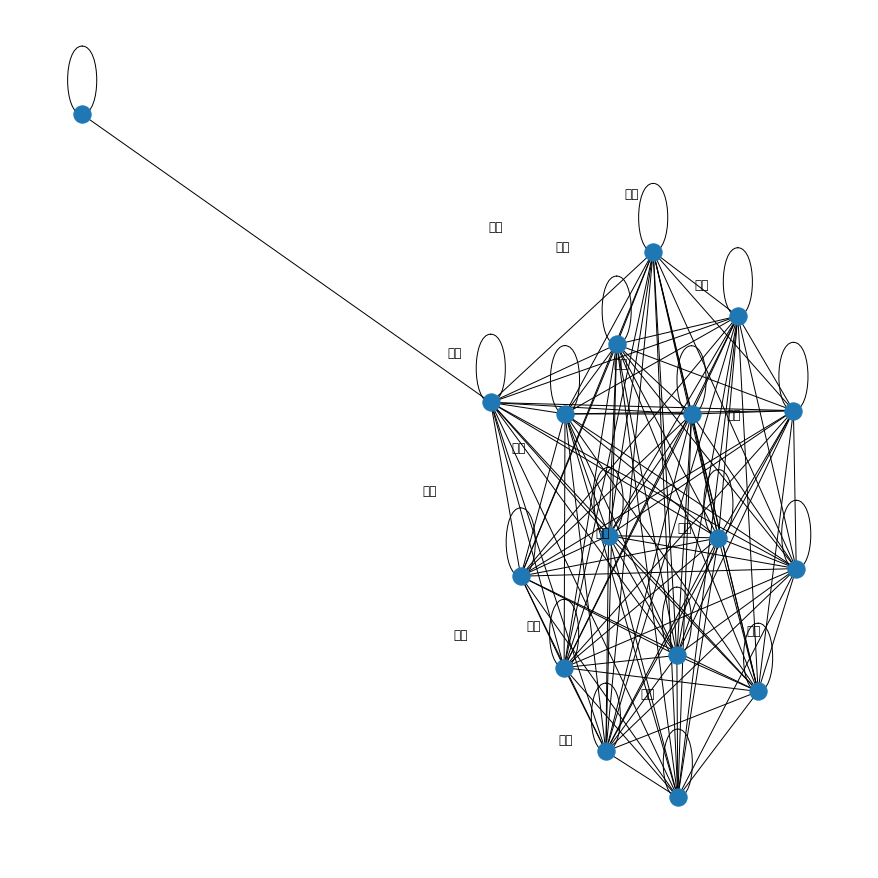

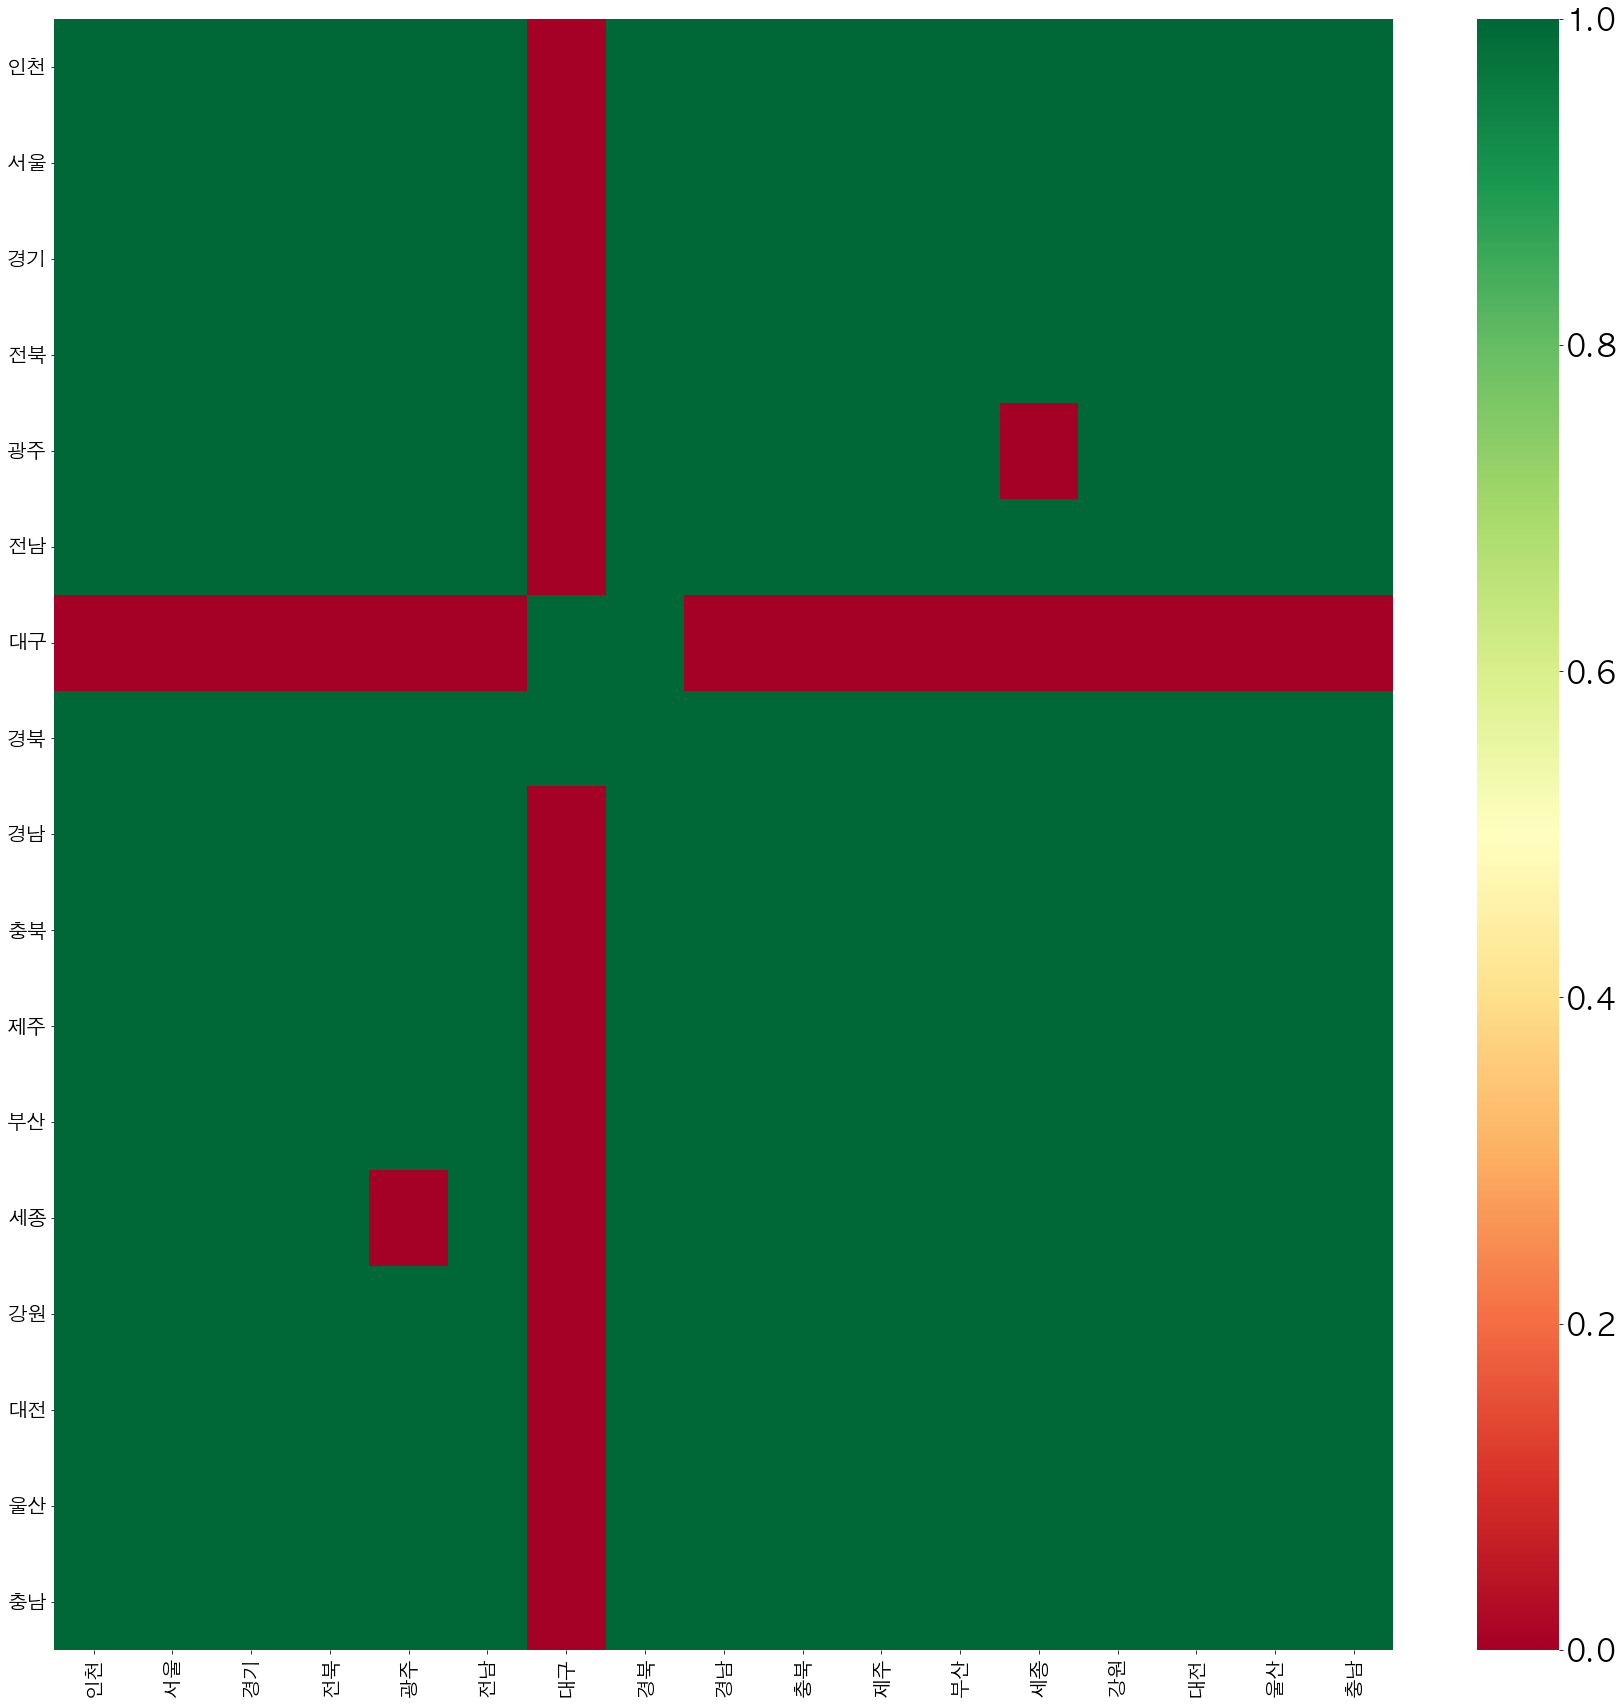

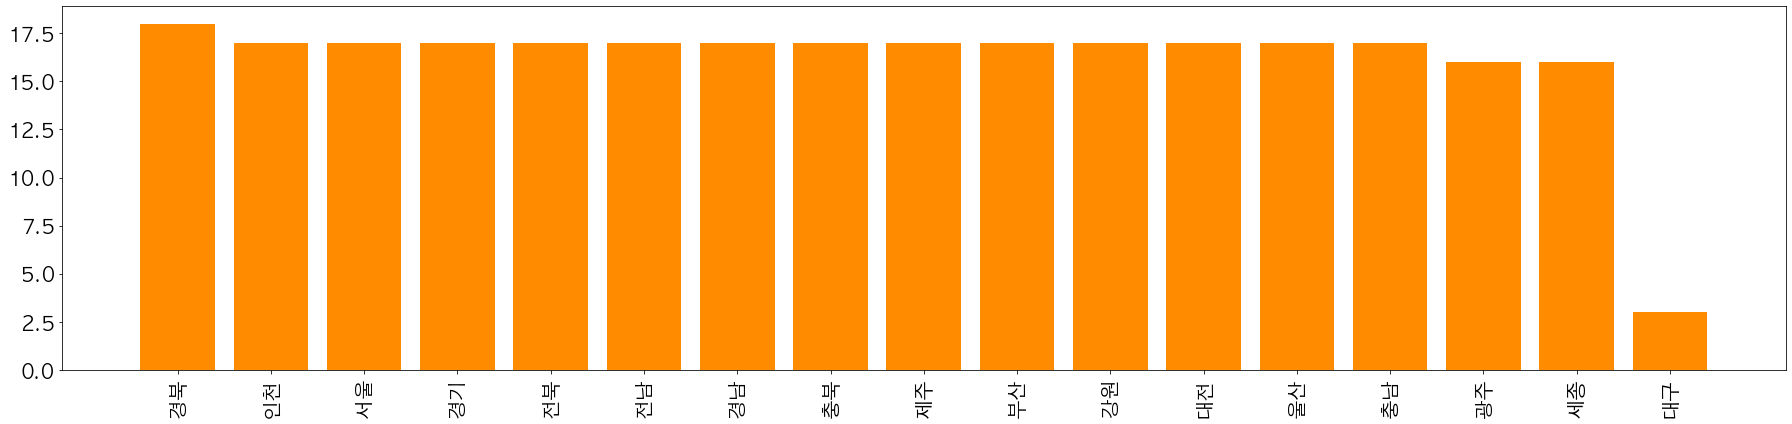

<Figure size 432x288 with 0 Axes>

In [45]:
kn = KoreaNetwork(data = daily_df_state,
                  region_type = "state",
                  save_path = save_path)
edge_df = kn.make_network(threshold=0.3)
kn.draw_heatmap()
kn.save_network_html()
kn.save_degree_dist()

In [ ]:
import seaborn as sns
adj_matrix_162 = (daily_df_city.corr(method='pearson') > 0.3).astype(int)
adj_matrix_162

corrmat = daily_df_city.corr()
corrmat = adj_matrix_162
top_corr_features = corrmat.index
plt.figure(figsize=(30,30))
plt.rcParams["font.family"] = 'Malgun Gothic'
g=sns.heatmap(corrmat,cmap="RdYlGn") #annot=True,

cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)

plt.yticks(fontsize=20, rotation=0)
plt.xticks(fontsize=20, rotation=90)

import networkx as nx
import matplotlib
G = nx.Graph(corrmat)
A = nx.adjacency_matrix(G)


plt.figure(figsize=(12,12))
nx.draw(G)
labels = nx.draw_networkx_labels(G, pos=nx.spring_layout(G))
print(G.degree)

from pyvis.network import Network

# nt3 = Network("2000px", "2000px", directed=True, heading= 'state')
# nt3 = net.Network("80%", "80%", directed=False, heading= 'state', bgcolor='#222222', font_color='white')
nt3 = Network("600px", "600px", directed=False, heading= 'state', bgcolor='#222222', font_color='white')

nt3.from_nx(G)
nt3.show_buttons(filter_=['physics'])
nt3.toggle_physics(True)
nt3.show("city.html")

deg_dist = dict(G.degree)
deg_dist = sorted(deg_dist.items(), key = lambda item: item[1], reverse = True)



sorted_x, sorted_y = [],[]
for i in deg_dist:
    sorted_x.append(i[0])
    sorted_y.append(i[1])


plt.figure(figsize=(25,6))
plt.bar(sorted_x, sorted_y, color ='darkorange')
plt.xticks(rotation = 90, fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
G.add_node('서울 서울', asd=2)

In [ ]:
G.nodes['서울 서울'] # 이렇게 노드 피처 추가하면 되는구나.

In [ ]:
adj_matrix_17 = (daily_df_state.corr(method='pearson') > 0.6).astype(int)
adj_matrix_17

corrmat = daily_df_state.corr()
corrmat = adj_matrix_17
top_corr_features = corrmat.index
plt.figure(figsize=(30,30))
plt.rcParams["font.family"] = 'Malgun Gothic'
g=sns.heatmap(corrmat,cmap="RdYlGn") #annot=True,

cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)

plt.yticks(fontsize=20, rotation=0)
plt.xticks(fontsize=20, rotation=90)

import networkx as nx
import matplotlib
G = nx.Graph(corrmat)
A = nx.adjacency_matrix(G)


plt.figure(figsize=(12,12))
nx.draw(G)
labels = nx.draw_networkx_labels(G, pos=nx.spring_layout(G))
print(G.degree)

from pyvis.network import Network
from pyvis import network as net

# nt3 = Network("2000px", "2000px", directed=True, heading= 'state')
# nt3 = net.Network("80%", "80%", directed=False, heading= 'state', bgcolor='#222222', font_color='white')
nt3 = Network("600px", "600px", directed=False, heading= 'state', bgcolor='#222222', font_color='white')

nt3.from_nx(G)
nt3.show_buttons(filter_=['physics'])
nt3.toggle_physics(True)
nt3.show("state.html")

deg_dist = dict(G.degree)
deg_dist = sorted(deg_dist.items(), key = lambda item: item[1], reverse = True)



sorted_x, sorted_y = [],[]
for i in deg_dist:
    sorted_x.append(i[0])
    sorted_y.append(i[1])


plt.figure(figsize=(25,6))
plt.bar(sorted_x, sorted_y, color ='darkorange')
plt.xticks(rotation = 90, fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()